In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from math import sqrt
from scipy.stats import pearsonr, spearmanr

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LassoLars, LinearRegression, TweedieRegressor

import acquire
import prepare
import explore
import model

%matplotlib inline
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")

seed = 42

# acquire

In [2]:
df = acquire.get_zillow()

In [3]:
df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,10804942,3.0,2.0,1175.0,327859.0,1953.0,4050.73,6037.0
1,14207926,3.0,2.0,1630.0,63948.0,1953.0,852.29,6037.0
2,10986950,2.0,2.0,1206.0,356218.0,1954.0,4393.33,6037.0
3,14207492,3.0,2.0,1790.0,242773.0,1964.0,3037.37,6037.0
4,11147606,3.0,2.0,1400.0,251246.0,1953.0,3081.31,6037.0


In [4]:
df = prepare.prep_zillow(df)

In [5]:
df.head()

,bedrooms,bathrooms,sqft,tax_value,year_built,fips
0,3.0,2.0,1175.0,327859.0,1953.0,6037.0
1,3.0,2.0,1630.0,63948.0,1953.0,6037.0
2,2.0,2.0,1206.0,356218.0,1954.0,6037.0
3,3.0,2.0,1790.0,242773.0,1964.0,6037.0
4,3.0,2.0,1400.0,251246.0,1953.0,6037.0


In [6]:
df.isna().sum()

bedrooms      0
bathrooms     0
sqft          0
tax_value     0
year_built    0
fips          0
dtype: int64

In [7]:
df.columns

Index(['bedrooms', 'bathrooms', 'sqft', 'tax_value', 'year_built', 'fips'], dtype='object')

In [8]:
cols = ['bedrooms', 'bathrooms', 'sqft', 'year_built']

In [9]:
prepare.remove_outliers(df, 2, cols)

,bedrooms,bathrooms,sqft,tax_value,year_built,fips
0,3.0,2.0,1175.0,327859.0,1953.0,6037.0
1,3.0,2.0,1630.0,63948.0,1953.0,6037.0
2,2.0,2.0,1206.0,356218.0,1954.0,6037.0
3,3.0,2.0,1790.0,242773.0,1964.0,6037.0
4,3.0,2.0,1400.0,251246.0,1953.0,6037.0
...,...,...,...,...,...,...
56075,3.0,2.0,1400.0,318206.0,1951.0,6037.0
56076,4.0,2.0,1446.0,140804.0,1951.0,6037.0
56077,4.0,2.0,1584.0,412114.0,1955.0,6037.0
56078,4.0,2.0,1584.0,186627.0,1955.0,6037.0


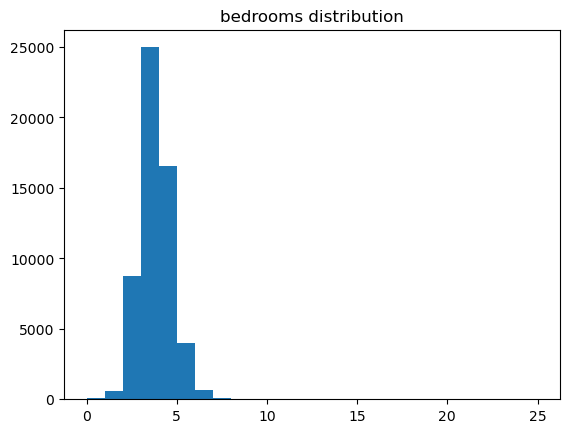

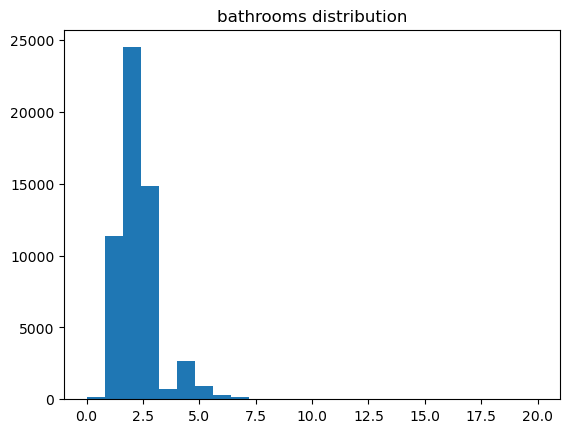

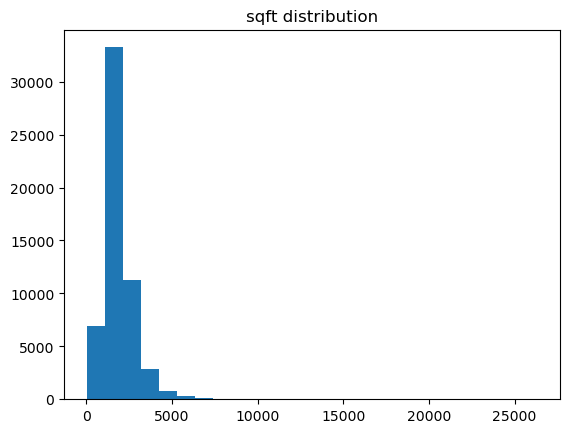

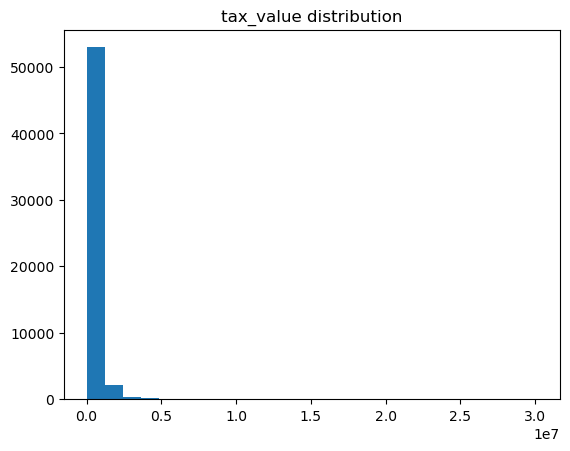

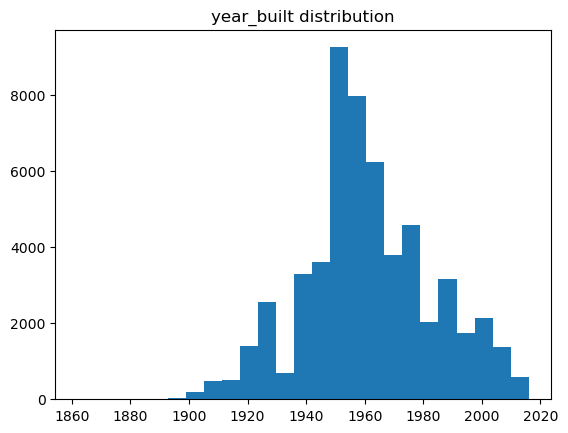

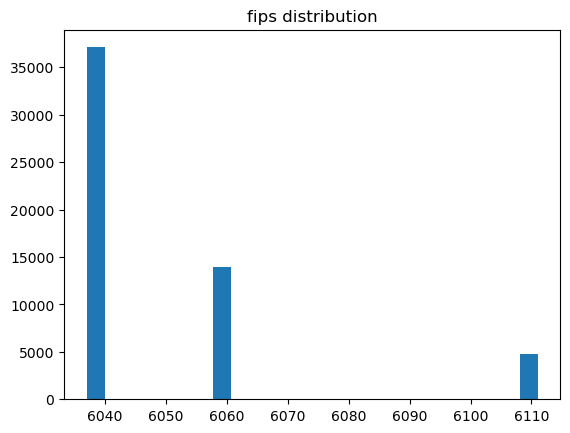

In [10]:
for col in df:

    plt.hist(df[col], bins=25)
    plt.title(f'{col} distribution')
    plt.show()

In [11]:
train, validate, test = prepare.subset_df(df)

(33441, 6) (11147, 6) (11148, 6)


In [12]:
train.head()

,bedrooms,bathrooms,sqft,tax_value,year_built,fips
12634,2.0,2.0,1248.0,832186.0,1962.0,6037.0
18194,3.0,2.0,1703.0,543910.0,1963.0,6059.0
43422,3.0,2.5,1602.0,559167.0,1994.0,6059.0
41163,4.0,2.0,1375.0,131876.0,1954.0,6037.0
47308,3.0,2.0,1630.0,583042.0,1950.0,6037.0


In [13]:
X_train, y_train, X_validate, y_validate, X_test, y_test = model.xy_subsets(train, validate, test, 'tax_value')

In [14]:
cols = ['sqft', 'year_built']

X_train_scaled, X_validate_scaled, X_test_scaled = prepare.scale_data(X_train, X_validate, X_test, MinMaxScaler(), cols)

In [15]:
X_train_scaled

,bedrooms,bathrooms,sqft,year_built,fips
12634,2.0,2.0,0.045197,0.649351,6037.0
18194,3.0,2.0,0.062507,0.655844,6059.0
43422,3.0,2.5,0.058665,0.857143,6059.0
41163,4.0,2.0,0.050029,0.597403,6037.0
47308,3.0,2.0,0.059730,0.571429,6037.0
...,...,...,...,...,...
45030,5.0,6.0,0.177364,0.941558,6037.0
54685,3.0,2.0,0.059844,0.694805,6059.0
38399,4.0,4.0,0.108731,0.584416,6037.0
862,5.0,6.0,0.205707,0.909091,6037.0


In [16]:
X_train_scaled = pd.get_dummies(X_train_scaled, columns=['bedrooms', 'bathrooms', 'fips'])

In [18]:
X_train_scaled

,sqft,year_built,bedrooms_0.0,bedrooms_1.0,bedrooms_2.0,bedrooms_3.0,bedrooms_4.0,bedrooms_5.0,bedrooms_6.0,bedrooms_7.0,bedrooms_8.0,bedrooms_9.0,bedrooms_10.0,bedrooms_25.0,bathrooms_0.0,bathrooms_1.0,bathrooms_1.5,bathrooms_2.0,bathrooms_2.5,bathrooms_3.0,bathrooms_3.5,bathrooms_4.0,bathrooms_4.5,bathrooms_5.0,bathrooms_5.5,bathrooms_6.0,bathrooms_6.5,bathrooms_7.0,bathrooms_7.5,bathrooms_8.0,bathrooms_8.5,bathrooms_9.0,bathrooms_9.5,bathrooms_10.0,bathrooms_11.0,bathrooms_13.0,bathrooms_19.5,bathrooms_20.0,fips_6037.0,fips_6059.0,fips_6111.0
12634,0.045197,0.649351,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
18194,0.062507,0.655844,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
43422,0.058665,0.857143,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
41163,0.050029,0.597403,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
47308,0.059730,0.571429,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45030,0.177364,0.941558,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
54685,0.059844,0.694805,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
38399,0.108731,0.584416,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
862,0.205707,0.909091,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [51]:
def rfe(n_features, X_train, y_train):
    
    lm = LinearRegression()
    rfe = RFE(lm, n_features_to_select=n_features)

    rfe.fit(X_train, y_train)

    ranks = rfe.ranking_
    columns = X_train.columns.tolist()
    
    feature_ranks = pd.DataFrame({'ranking': ranks,
                              'feature': columns})

    feature_ranks = feature_ranks.sort_values('ranking')

    return pd.DataFrame(feature_ranks).head(n_features)

In [57]:
rfe1 = rfe(8, X_train_scaled, y_train)

In [64]:
rfe1['feature']

36    bathrooms_19.5
6       bedrooms_4.0
7       bedrooms_5.0
8       bedrooms_6.0
9       bedrooms_7.0
10      bedrooms_8.0
11      bedrooms_9.0
13     bedrooms_25.0
Name: feature, dtype: object

In [135]:
X_train_scaled1

,bathrooms_19.5,bedrooms_4.0,bedrooms_5.0,bedrooms_6.0,bedrooms_7.0,bedrooms_8.0,bedrooms_9.0,bedrooms_25.0
12634,0,0,0,0,0,0,0,0
18194,0,0,0,0,0,0,0,0
43422,0,0,0,0,0,0,0,0
41163,0,1,0,0,0,0,0,0
47308,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
45030,0,0,1,0,0,0,0,0
54685,0,0,0,0,0,0,0,0
38399,0,1,0,0,0,0,0,0
862,0,0,1,0,0,0,0,0


In [80]:
X_train_scaled1 = X_train_scaled[['bathrooms_19.5', 'bedrooms_4.0', 'bedrooms_5.0', 'bedrooms_6.0', 
               'bedrooms_7.0', 'bedrooms_8.0', 'bedrooms_9.0', 'bedrooms_25.0']]

In [54]:
def f_selector(k, X_train, y_train):
    
    f_selector = SelectKBest(f_regression, k=k)

    f_selector.fit(X_train_scaled, y_train)

    f_select_mask = f_selector.get_support()

    select_k_best_features = X_train_scaled.iloc[:,f_select_mask]
    
    #print(select_k_best_features.head(k))
    
    return pd.DataFrame(select_k_best_features)

In [136]:
X_train_scaled.head()

,sqft,year_built,bedrooms_0.0,bedrooms_1.0,bedrooms_2.0,bedrooms_3.0,bedrooms_4.0,bedrooms_5.0,bedrooms_6.0,bedrooms_7.0,bedrooms_8.0,bedrooms_9.0,bedrooms_10.0,bedrooms_25.0,bathrooms_0.0,bathrooms_1.0,bathrooms_1.5,bathrooms_2.0,bathrooms_2.5,bathrooms_3.0,bathrooms_3.5,bathrooms_4.0,bathrooms_4.5,bathrooms_5.0,bathrooms_5.5,bathrooms_6.0,bathrooms_6.5,bathrooms_7.0,bathrooms_7.5,bathrooms_8.0,bathrooms_8.5,bathrooms_9.0,bathrooms_9.5,bathrooms_10.0,bathrooms_11.0,bathrooms_13.0,bathrooms_19.5,bathrooms_20.0,fips_6037.0,fips_6059.0,fips_6111.0
12634,0.045197,0.649351,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
18194,0.062507,0.655844,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
43422,0.058665,0.857143,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
41163,0.050029,0.597403,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
47308,0.059730,0.571429,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [55]:
X_train_scaled2 = f_selector(8, X_train_scaled, y_train)

In [56]:
X_train_scaled2

,sqft,year_built,bedrooms_5.0,bathrooms_2.0,bathrooms_5.0,bathrooms_6.0,bathrooms_7.0,bathrooms_9.0
12634,0.045197,0.649351,0,1,0,0,0,0
18194,0.062507,0.655844,0,1,0,0,0,0
43422,0.058665,0.857143,0,0,0,0,0,0
41163,0.050029,0.597403,0,1,0,0,0,0
47308,0.059730,0.571429,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
45030,0.177364,0.941558,1,0,0,1,0,0
54685,0.059844,0.694805,0,1,0,0,0,0
38399,0.108731,0.584416,0,0,0,0,0,0
862,0.205707,0.909091,1,0,0,1,0,0


In [118]:
lm = LinearRegression()

lm.fit(X_train_scaled1, y_train)

lm_preds = lm.predict(X_train_scaled1)

preds_df = pd.DataFrame({'actual': y_train,
                         'lm_preds': lm_preds})

In [119]:
preds_df['baseline_avg'] = y_train.mean()

In [120]:
sqrt(mean_squared_error(preds_df['actual'], preds_df['baseline_avg']))

555332.5503557529

In [121]:
preds_df

,actual,lm_preds,baseline_avg
12634,832186.0,355284.520085,453681.877755
18194,543910.0,355284.520085,453681.877755
43422,559167.0,355284.520085,453681.877755
41163,131876.0,517863.141310,453681.877755
47308,583042.0,355284.520085,453681.877755
...,...,...,...
45030,4275000.0,841249.258422,453681.877755
54685,234378.0,355284.520085,453681.877755
38399,1180635.0,517863.141310,453681.877755
862,1098926.0,841249.258422,453681.877755


In [122]:
lm_rmse = sqrt(mean_squared_error(preds_df['lm_preds'], preds_df['actual']))

lm_rmse

522292.5395835447

In [96]:
lm = LinearRegression()

lm.fit(X_train_scaled2, y_train)

lm_preds = lm.predict(X_train_scaled2)

preds_df = pd.DataFrame({'actual': y_train,
                         'lm_preds': lm_preds})

In [123]:
lasso = LassoLars(alpha=.1)

lasso.fit(X_train_scaled1, y_train)

lasso_preds = lasso.predict(X_train_scaled1)

preds_df['lasso_preds'] = lasso_preds

preds_df.head()

,actual,lm_preds,baseline_avg,lasso_preds
12634,832186.0,355284.520085,453681.877755,355311.475338
18194,543910.0,355284.520085,453681.877755,355311.475338
43422,559167.0,355284.520085,453681.877755,355311.475338
41163,131876.0,517863.141310,453681.877755,517834.899715
47308,583042.0,355284.520085,453681.877755,355311.475338


In [124]:
lasso_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_preds']))
lasso_rmse

522292.5424520725

In [125]:
pf = PolynomialFeatures(degree=2)

pf.fit(X_train_scaled1, y_train)

X_polynomial = pf.transform(X_train_scaled1)

In [126]:
lm2 = LinearRegression()

lm2.fit(X_polynomial, y_train)

preds_df['poly_preds'] = lm2.predict(X_polynomial)

preds_df.head()

,actual,lm_preds,baseline_avg,lasso_preds,poly_preds
12634,832186.0,355284.520085,453681.877755,355311.475338,355276.334961
18194,543910.0,355284.520085,453681.877755,355311.475338,355276.334961
43422,559167.0,355284.520085,453681.877755,355311.475338,355276.334961
41163,131876.0,517863.141310,453681.877755,517834.899715,519616.215332
47308,583042.0,355284.520085,453681.877755,355311.475338,355276.334961


In [127]:
lm2_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['poly_preds']))

lm2_rmse

522301.9641252303

In [128]:
lasso2 = LassoLars(alpha=.33)

lasso2.fit(X_polynomial, y_train)

lasso2_preds = lasso2.predict(X_polynomial)

preds_df['lasso_poly'] = lasso2_preds

preds_df.head()

,actual,lm_preds,baseline_avg,lasso_preds,poly_preds,lasso_poly
12634,832186.0,355284.520085,453681.877755,355311.475338,355276.334961,385286.174887
18194,543910.0,355284.520085,453681.877755,355311.475338,355276.334961,385286.174887
43422,559167.0,355284.520085,453681.877755,355311.475338,355276.334961,385286.174887
41163,131876.0,517863.141310,453681.877755,517834.899715,519616.215332,485994.873357
47308,583042.0,355284.520085,453681.877755,355311.475338,355276.334961,385286.174887


In [129]:
lasso2_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_poly']))

lasso2_rmse

525130.0767301625

In [130]:
tweedie = TweedieRegressor(power=0)

tweedie.fit(X_train_scaled1, y_train)

tweedie_preds = tweedie.predict(X_train_scaled1)

preds_df['tweedie_norm_preds'] = tweedie_preds

preds_df.head()

,actual,lm_preds,baseline_avg,lasso_preds,poly_preds,lasso_poly,tweedie_norm_preds
12634,832186.0,355284.520085,453681.877755,355311.475338,355276.334961,385286.174887,446838.658456
18194,543910.0,355284.520085,453681.877755,355311.475338,355276.334961,385286.174887,446838.658456
43422,559167.0,355284.520085,453681.877755,355311.475338,355276.334961,385286.174887,446838.658456
41163,131876.0,517863.141310,453681.877755,517834.899715,519616.215332,485994.873357,463035.584384
47308,583042.0,355284.520085,453681.877755,355311.475338,355276.334961,385286.174887,446838.658456


In [131]:
tweedie_norm = sqrt(mean_squared_error(preds_df['actual'], preds_df['tweedie_norm_preds']))

tweedie_norm

553318.8159985825

In [132]:
tweedie = TweedieRegressor(power=1)

tweedie.fit(X_train_scaled1, y_train)

tweedie_preds = tweedie.predict(X_train_scaled1)

preds_df['tweedie_poisson_preds'] = tweedie_preds

preds_df.head()

,actual,lm_preds,baseline_avg,lasso_preds,poly_preds,lasso_poly,tweedie_norm_preds,tweedie_poisson_preds
12634,832186.0,355284.520085,453681.877755,355311.475338,355276.334961,385286.174887,446838.658456,355304.822125
18194,543910.0,355284.520085,453681.877755,355311.475338,355276.334961,385286.174887,446838.658456,355304.822125
43422,559167.0,355284.520085,453681.877755,355311.475338,355276.334961,385286.174887,446838.658456,355304.822125
41163,131876.0,517863.141310,453681.877755,517834.899715,519616.215332,485994.873357,463035.584384,517861.635245
47308,583042.0,355284.520085,453681.877755,355311.475338,355276.334961,385286.174887,446838.658456,355304.822125


In [133]:
tweedie_poisson = sqrt(mean_squared_error(preds_df['actual'], preds_df['tweedie_poisson_preds']))

tweedie_poisson

522293.0326859192

In [134]:
results = pd.DataFrame({'model':['linear', 'lasso', 'linear_poly', 'lasso_poly', 'tweedie_norm', 'tweedie_poisson'],
              'rmse':[lm_rmse, lasso_rmse, lm2_rmse, lasso2_rmse, tweedie_norm, tweedie_poisson]})

results

,model,rmse
0,linear,522292.539584
1,lasso,522292.542452
2,linear_poly,522301.964125
3,lasso_poly,525130.076730
4,tweedie_norm,553318.815999
5,tweedie_poisson,522293.032686


In [157]:
results = pd.DataFrame({'model':['linear', 'lasso', 'linear_poly', 'lasso_poly', 'tweedie_norm', 'tweedie_poisson'],
              'rmse':[lm_rmse, lasso_rmse, lm2_rmse, lasso2_rmse, tweedie_norm, tweedie_poisson]})

results

,model,rmse
0,linear,411320.176041
1,lasso,411320.179771
2,linear_poly,398541.984882
3,lasso_poly,405091.039643
4,tweedie_norm,549029.479710
5,tweedie_poisson,637187.590005


In [138]:
lm = LinearRegression()

lm.fit(X_train_scaled2, y_train)

lm_preds = lm.predict(X_train_scaled2)

preds_df = pd.DataFrame({'actual': y_train,
                         'lm_preds': lm_preds})

In [139]:
preds_df['baseline_avg'] = y_train.mean()

In [140]:
sqrt(mean_squared_error(preds_df['actual'], preds_df['baseline_avg']))

555332.5503557529

In [141]:
lm_rmse = sqrt(mean_squared_error(preds_df['lm_preds'], preds_df['actual']))

lm_rmse

411320.1760413849

In [159]:
X_train_scaled2.shape

(33441, 8)

In [142]:
lasso = LassoLars(alpha=.1)

lasso.fit(X_train_scaled2, y_train)

lasso_preds = lasso.predict(X_train_scaled2)

preds_df['lasso_preds'] = lasso_preds

preds_df.head()

,actual,lm_preds,baseline_avg,lasso_preds
12634,832186.0,220470.541249,453681.877755,220500.710956
18194,543910.0,378506.183835,453681.877755,378527.424292
43422,559167.0,320559.280982,453681.877755,320589.354273
41163,131876.0,276081.512836,453681.877755,276098.287708
47308,583042.0,370985.513495,453681.877755,370991.278574


In [143]:
lasso_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_preds']))
lasso_rmse

411320.17977121135

In [146]:
pf = PolynomialFeatures(degree=2)

pf.fit(X_train_scaled2, y_train)

X_polynomial = pf.transform(X_train_scaled2)

In [147]:
lm2 = LinearRegression()

lm2.fit(X_polynomial, y_train)

preds_df['poly_preds'] = lm2.predict(X_polynomial)

preds_df.head()

,actual,lm_preds,baseline_avg,lasso_preds,poly_preds
12634,832186.0,220470.541249,453681.877755,220500.710956,258064.312500
18194,543910.0,378506.183835,453681.877755,378527.424292,351509.625000
43422,559167.0,320559.280982,453681.877755,320589.354273,332310.429688
41163,131876.0,276081.512836,453681.877755,276098.287708,297089.414062
47308,583042.0,370985.513495,453681.877755,370991.278574,353053.226562


In [148]:
lm2_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['poly_preds']))

lm2_rmse

398541.98488211224

In [151]:
lasso2 = LassoLars(alpha=.1)

lasso2.fit(X_polynomial, y_train)

lasso2_preds = lasso2.predict(X_polynomial)

preds_df['lasso_poly'] = lasso2_preds

In [152]:
lasso2_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_poly']))

lasso2_rmse

405091.0396430565

In [153]:
tweedie = TweedieRegressor(power=0)

tweedie.fit(X_train_scaled2, y_train)

tweedie_preds = tweedie.predict(X_train_scaled2)

preds_df['tweedie_norm_preds'] = tweedie_preds

preds_df.head()

,actual,lm_preds,baseline_avg,lasso_preds,poly_preds,lasso_poly,tweedie_norm_preds
12634,832186.0,220470.541249,453681.877755,220500.710956,258064.312500,245778.294200,427770.054678
18194,543910.0,378506.183835,453681.877755,378527.424292,351509.625000,366128.625771,428105.252530
43422,559167.0,320559.280982,453681.877755,320589.354273,332310.429688,359474.792117,473466.934194
41163,131876.0,276081.512836,453681.877755,276098.287708,297089.414062,282722.642850,426928.220487
47308,583042.0,370985.513495,453681.877755,370991.278574,353053.226562,354287.255264,426600.829238


In [154]:
tweedie_norm = sqrt(mean_squared_error(preds_df['actual'], preds_df['tweedie_norm_preds']))

tweedie_norm

549029.4797100789

In [155]:
tweedie = TweedieRegressor(power=1)

tweedie.fit(X_train_scaled2, y_train)

tweedie_preds = tweedie.predict(X_train_scaled2)

preds_df['tweedie_norm_preds'] = tweedie_preds

preds_df.head()

,actual,lm_preds,baseline_avg,lasso_preds,poly_preds,lasso_poly,tweedie_norm_preds
12634,832186.0,220470.541249,453681.877755,220500.710956,258064.312500,245778.294200,312750.142515
18194,543910.0,378506.183835,453681.877755,378527.424292,351509.625000,366128.625771,346430.346494
43422,559167.0,320559.280982,453681.877755,320589.354273,332310.429688,359474.792117,474121.053458
41163,131876.0,276081.512836,453681.877755,276098.287708,297089.414062,282722.642850,311426.862920
47308,583042.0,370985.513495,453681.877755,370991.278574,353053.226562,354287.255264,323896.493047


In [156]:
tweedie_poisson = sqrt(mean_squared_error(preds_df['actual'], preds_df['tweedie_norm_preds']))

tweedie_poisson

637187.5900047361